<a href="https://colab.research.google.com/github/Rukayat-spec/ADS-STATISTICS-AND-TRENDS/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [56]:
pip install keras-tuner

In [57]:
!pip install scikeras

In [58]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import random
import tensorflow as tf

import keras_tuner as kt


In [59]:
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/MyDrive/Msc Project')

Mounted at /content/drive


**Load the CSV file into a DataFrame**


In [60]:
stock_data = pd.read_csv("GBP_EUR_Pair_Historical_Data.csv")
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-17,1.4271,1.4286,1.4237,1.4261,1.4261,0.0
1,2003-09-18,1.4261,1.4382,1.4239,1.4370,1.4370,0.0
2,2003-09-19,1.4368,1.4411,1.4333,1.4372,1.4372,0.0
3,2003-09-22,1.4354,1.4408,1.4331,1.4360,1.4360,0.0
4,2003-09-23,1.4360,1.4436,1.4341,1.4426,1.4426,0.0


In [61]:
# Check the shape of the dataset
print(f'The dataset contains {stock_data.shape[0]} rows and {stock_data.shape[1]} columns.')

The dataset contains 5402 rows and 7 columns.


In [62]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5402 non-null   object 
 1   Open       5373 non-null   float64
 2   High       5373 non-null   float64
 3   Low        5373 non-null   float64
 4   Close      5373 non-null   float64
 5   Adj Close  5373 non-null   float64
 6   Volume     5373 non-null   float64
dtypes: float64(6), object(1)
memory usage: 295.5+ KB


In [63]:
# Display summary statistics
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.0
mean,1.242865,1.246882,1.238706,1.242842,1.242842,0.0
std,0.130321,0.130407,0.130163,0.130289,0.130289,0.0
min,1.015700,1.032400,1.015700,1.015700,1.015700,0.0
25%,1.145800,1.149510,1.141360,1.145690,1.145690,0.0
50%,1.181800,1.185800,1.177800,1.181700,1.181700,0.0
75%,1.350400,1.355800,1.344600,1.349400,1.349400,0.0
max,1.526200,1.529500,1.521400,1.526200,1.526200,0.0


In [64]:
# Display the sum of null values for each column
stock_data.isnull().sum()

Date          0
Open         29
High         29
Low          29
Close        29
Adj Close    29
Volume       29
dtype: int64

In [65]:
# Remove rows with null values in all columns
cleaned_stock_data = stock_data.dropna()

In [66]:
print(f'The dataset contains {cleaned_stock_data.shape[0]} rows and {cleaned_stock_data.shape[1]} columns.')

The dataset contains 5373 rows and 7 columns.


In [67]:
# Remove rows with missing values
cleaned_stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [68]:
cleaned_stock_data = cleaned_stock_data.drop(columns=['Adj Close','Volume'])
cleaned_stock_data

,Date,Open,High,Low,Close
0,2003-09-17,1.42710,1.42860,1.4237,1.42610
1,2003-09-18,1.42610,1.43820,1.4239,1.43700
2,2003-09-19,1.43680,1.44110,1.4333,1.43720
3,2003-09-22,1.43540,1.44080,1.4331,1.43600
4,2003-09-23,1.43600,1.44360,1.4341,1.44260
...,...,...,...,...,...
5397,2024-05-24,1.17370,1.17479,1.1718,1.17370
5398,2024-05-27,1.17380,1.17689,1.1735,1.17380
5399,2024-05-28,1.17581,1.17689,1.1738,1.17581
5400,2024-05-29,1.17562,1.17864,1.1741,1.17562


In [69]:
cleaned_stock_data.describe()

,Open,High,Low,Close
count,5373.000000,5373.000000,5373.000000,5373.000000
mean,1.242865,1.246882,1.238706,1.242842
std,0.130321,0.130407,0.130163,0.130289
min,1.015700,1.032400,1.015700,1.015700
25%,1.145800,1.149510,1.141360,1.145690
50%,1.181800,1.185800,1.177800,1.181700
75%,1.350400,1.355800,1.344600,1.349400
max,1.526200,1.529500,1.521400,1.526200


In [70]:
# Convert Date' column to datetime to ensure
cleaned_stock_data['Date'] = pd.to_datetime(cleaned_stock_data['Date'])
#df_cleaned.loc[:, 'Date'] = pd.to_datetime(cleaned_stock_data['Date'])
cleaned_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5373 entries, 0 to 5401
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5373 non-null   datetime64[ns]
 1   Open    5373 non-null   float64       
 2   High    5373 non-null   float64       
 3   Low     5373 non-null   float64       
 4   Close   5373 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 380.9 KB


**Using the box plot method to check for outliers in the dataset**

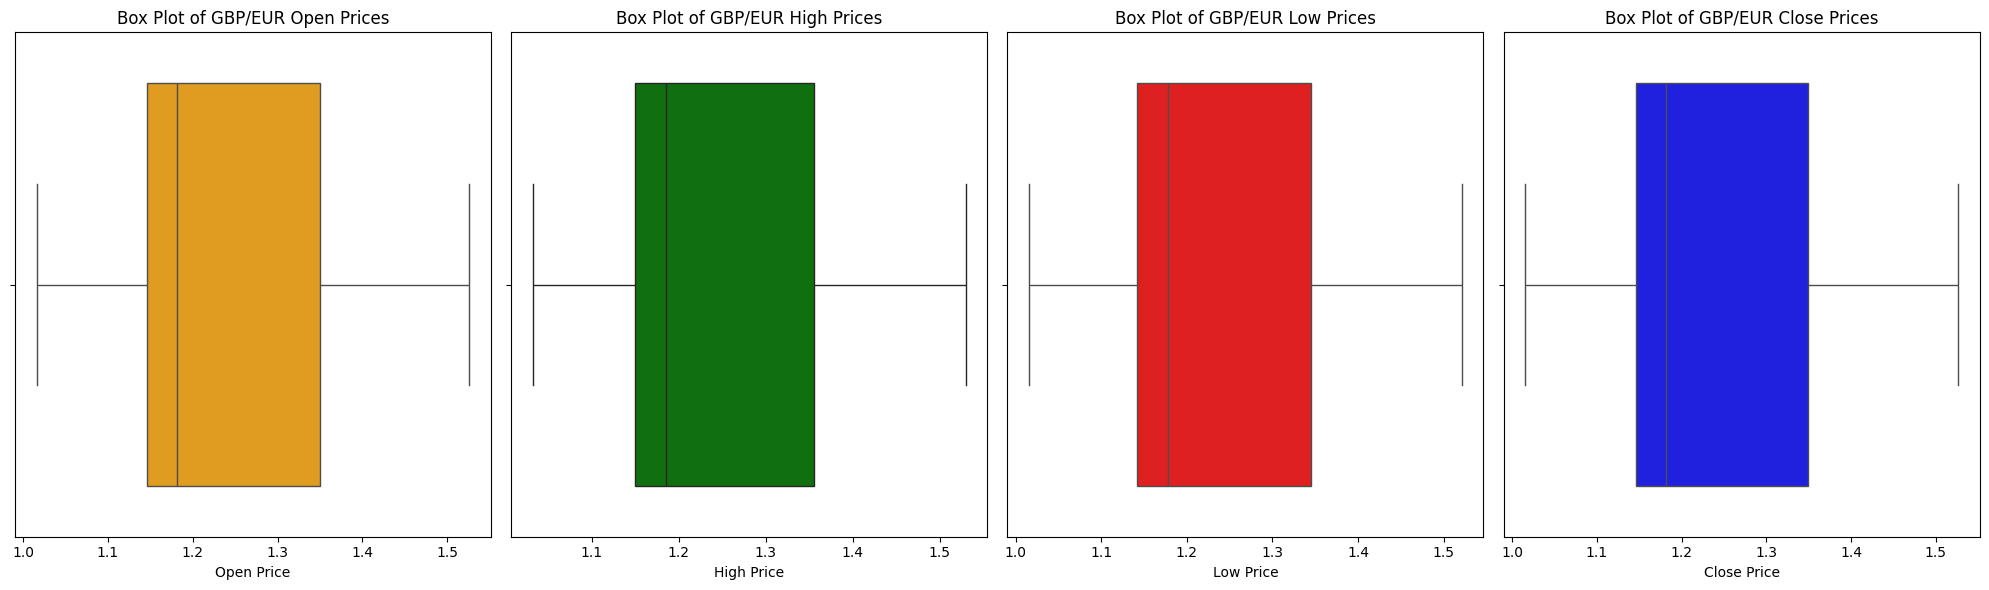

In [71]:

# Create a Sub DataFrame for the box plots
data_to_plot = cleaned_stock_data[['Open', 'High', 'Low', 'Close']]

# Create a figure with 4 horizontal box plots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# box plot for 'Open' prices
sns.boxplot(data=data_to_plot['Open'], ax=axs[0], color='orange', orient='h')
axs[0].set_title('Box Plot of GBP/EUR Open Prices')
axs[0].set_xlabel('Open Price')

# box plot for 'High' prices
sns.boxplot(data=data_to_plot['High'], ax=axs[1], color='green', orient='h')
axs[1].set_title('Box Plot of GBP/EUR High Prices')
axs[1].set_xlabel('High Price')

# box plot for 'Low' prices
sns.boxplot(data=data_to_plot['Low'], ax=axs[2], color='red', orient='h')
axs[2].set_title('Box Plot of GBP/EUR Low Prices')
axs[2].set_xlabel('Low Price')

# box plot for 'Close' prices
sns.boxplot(data=data_to_plot['Close'], ax=axs[3], color='blue', orient='h')
axs[3].set_title('Box Plot of GBP/EUR Close Prices')
axs[3].set_xlabel('Close Price')

# adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()


Box plots showing there is no outlier in any of the columns

**Visualizing the prices over the past 20 years to understand trends**

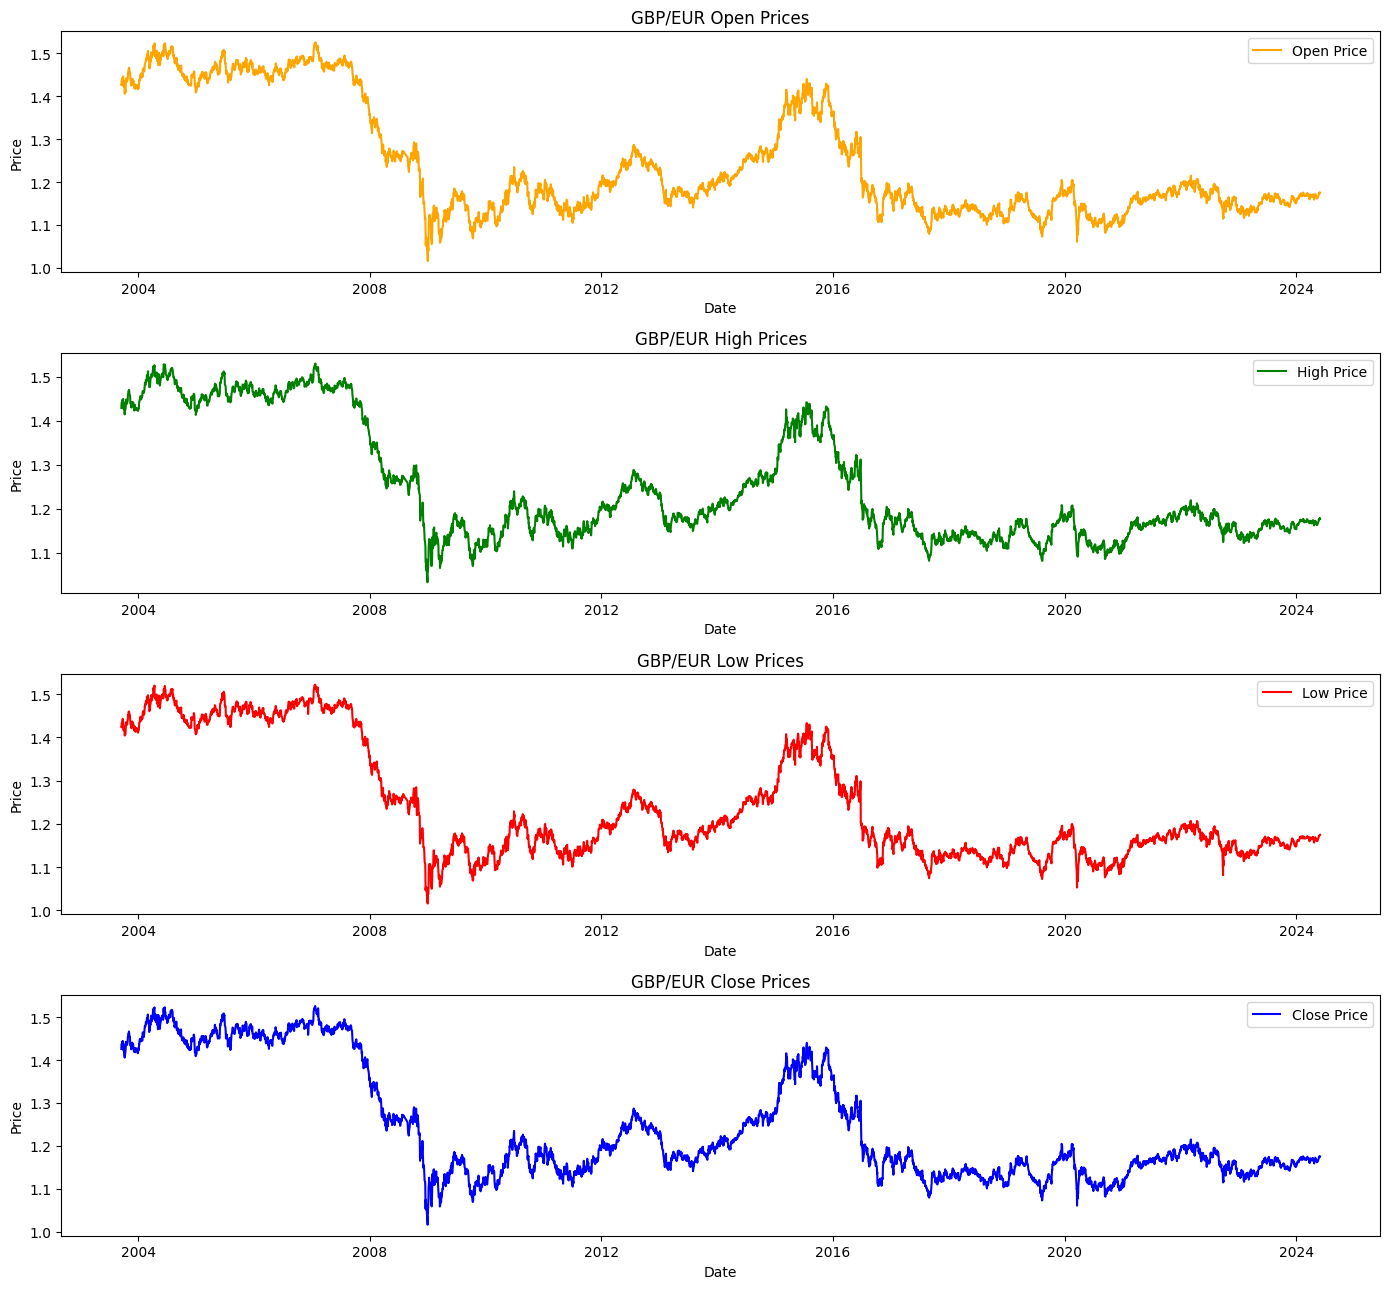

In [72]:
# Create a figure with 4 subplots without sharing x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13), sharex=False)

# Plot 'Open' prices
axs[0].plot(cleaned_stock_data['Date'], cleaned_stock_data['Open'], label='Open Price', color='orange')
axs[0].set_title('GBP/EUR Open Prices')
axs[0].set_ylabel('Price')
axs[0].set_xlabel('Date')
axs[0].legend()

# Plot 'High' prices
axs[1].plot(cleaned_stock_data['Date'], cleaned_stock_data['High'], label='High Price', color='green')
axs[1].set_title('GBP/EUR High Prices')
axs[1].set_ylabel('Price')
axs[1].set_xlabel('Date')
axs[1].legend()

# Plot 'Low' prices
axs[2].plot(cleaned_stock_data['Date'], cleaned_stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('GBP/EUR Low Prices')
axs[2].set_ylabel('Price')
axs[2].set_xlabel('Date')
axs[2].legend()

# Plot 'Close' prices
axs[3].plot(cleaned_stock_data['Date'], cleaned_stock_data['Close'], label='Close Price', color='blue')
axs[3].set_title('GBP/EUR Close Prices')
axs[3].set_ylabel('Price')
axs[3].set_xlabel('Date')
axs[3].legend()

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()



All four plots show a similar pattern of price movement, indicating that the opening, high, low, and closing prices are correlated.
There are significant fluctuations in prices around the 2008 due to financial crisis. After 2016, there is a notable downward trend, followed by a stabilization in recent years.
The charts highlighting the substantial impact of the global financial turmoil on the GBP/EUR currency pair.

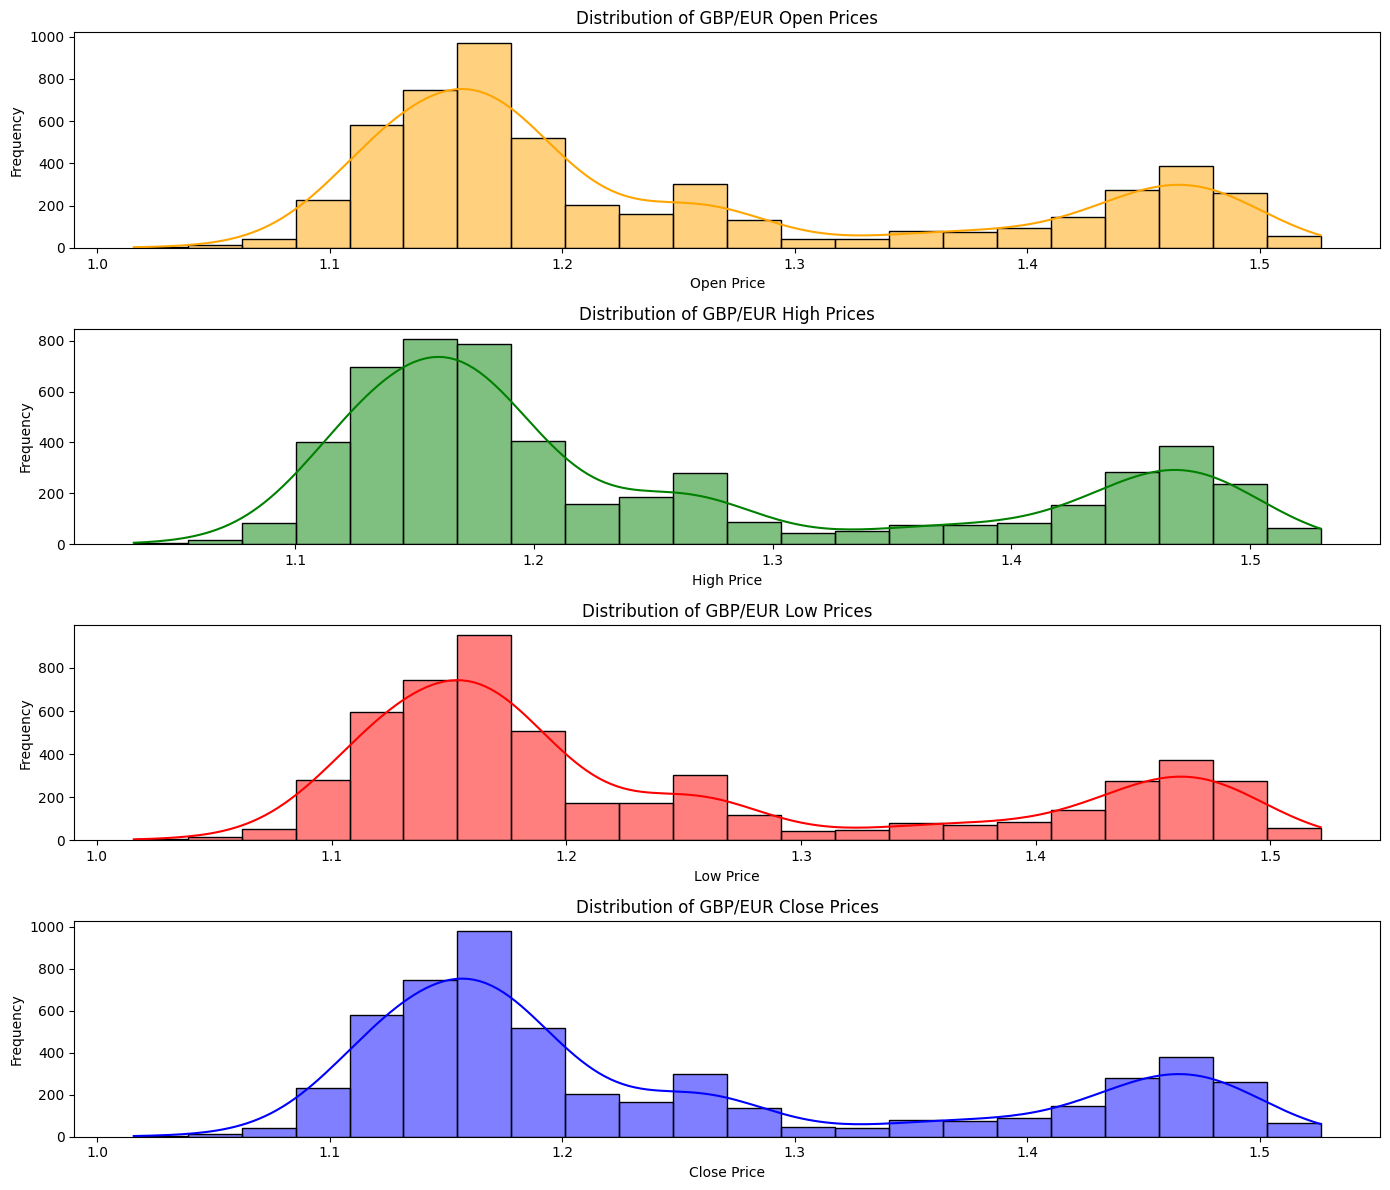

In [73]:
# using histogram to understand the distribution of prices of interest, Open, High, Low and Close.
"""Kernel Density Estimate(KDE) adds a smooth curve over the histogram, giving a
 continuous estimation of the probability density function of the data """

# Figure for the subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 12))
# Plot histogram for 'Open' prices
sns.histplot(cleaned_stock_data['Open'], kde=True, ax=axs[0], color='orange')
axs[0].set_title('Distribution of GBP/EUR Open Prices')
axs[0].set_xlabel('Open Price')
axs[0].set_ylabel('Frequency')

# Plot histogram for 'High' prices
sns.histplot(cleaned_stock_data['High'], kde=True, ax=axs[1], color='green')
axs[1].set_title('Distribution of GBP/EUR High Prices')
axs[1].set_xlabel('High Price')
axs[1].set_ylabel('Frequency')

# Plot histogram for 'Low' prices
sns.histplot(cleaned_stock_data['Low'], kde=True, ax=axs[2], color='red')
axs[2].set_title('Distribution of GBP/EUR Low Prices')
axs[2].set_xlabel('Low Price')
axs[2].set_ylabel('Frequency')

# Plot histogram for 'Close' prices
sns.histplot(cleaned_stock_data['Close'], kde=True, ax=axs[3], color='blue')
axs[3].set_title('Distribution of GBP/EUR Close Prices')
axs[3].set_xlabel('Close Price')
axs[3].set_ylabel('Frequency')

# adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()


All histograms show a bimodal distribution(2 peaks)

The first peak is between 1.1 and 1.2 and is slightly skewed to the right.
The second peak is between 1.4 and 1.5 and appears to be more symmetric(tending to be normally distributed).

**Adding technical indicators to better understand market dynamics and make informed trading decisions.**

In [74]:
# Exponential Moving Average(EMA)

def calculate_ema(df, span):
    """
    Calculate the Exponential Moving Average (EMA).

    Parameters:
    df (pandas DataFrame): The original dataframe.
    span (int): The span for the EMA.

    Returns:
    pandas Series: The EMA of the close prices.
    """
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate EMA 50 and EMA 200
cleaned_stock_data.loc[:,'EMA_50'] = calculate_ema(cleaned_stock_data, span=50)
cleaned_stock_data.loc[:,'EMA_200'] = calculate_ema(cleaned_stock_data, span=200)



# Moving average convergence/divergence (MACD)
def calculate_macd(df, short_span=12, long_span=26, signal_span=9):
    """
    Calculate the MACD, Signal Line, and MACD Histogram.

    Parameters:
    df (pandas DataFrame): The original dataframe.
    short_span (int): The span for the short-term EMA.
    long_span (int): The span for the long-term EMA.
    signal_span (int): The span for the Signal line.

    Returns:
    pandas DataFrame: The MACD, Signal line, and MACD Histogram.
    """
    short_ema = df['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_span, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    macd_histogram = macd - signal
    return pd.DataFrame({'MACD': macd, 'Signal': signal, 'MACD_Histogram': macd_histogram})

# Calculate MACD, Signal Line, and MACD Histogram
macd_df = calculate_macd(cleaned_stock_data)

# Add these components to the original DataFrame
cleaned_stock_data.loc[:,'MACD'] = macd_df['MACD']
cleaned_stock_data.loc[:, 'MACD_Signal'] = macd_df['Signal']
cleaned_stock_data.loc[:,'MACD_Histogram'] = macd_df['MACD_Histogram']



# Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Assuming df_cleaned is already loaded and includes EMA and MACD calculations
cleaned_stock_data.loc[:,'RSI'] = calculate_rsi(cleaned_stock_data)



#Average Directional Index (ADX)
def calculate_adx(df, window=14):
    """
    Calculate the Average Directional Index (ADX).

    Parameters:
    df (pandas DataFrame): The original dataframe.
    window (int): The period for calculating the ADX.

    Returns:
    pandas DataFrame: The ADX, plus directional indicator (DI+), and minus directional indicator (DI-).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Calculate directional movements
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    # Smooth the TR, plus_dm, and minus_dm
    atr = tr.rolling(window=window, min_periods=1).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))

    # Calculate the DX and ADX
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()

    return pd.DataFrame({'ADX': adx, 'Plus_DI': plus_di, 'Minus_DI': minus_di})

# Calculate ADX, Plus_DI, and Minus_DI
adx_df = calculate_adx(cleaned_stock_data)

# Add these components to the original DataFrame
cleaned_stock_data.loc[:,'ADX'] = adx_df['ADX']
cleaned_stock_data.loc[:,'Plus_DI'] = adx_df['Plus_DI']
cleaned_stock_data.loc[:,'Minus_DI'] = adx_df['Minus_DI']

# Drop rows with NaN values (if any) at the beginning of the dataset
cleaned_stock_data.dropna(inplace=True)


# Display the first few rows of the DataFrame to verify
cleaned_stock_data.shape




(5360, 14)

**Filtering the data set to the last three years for better visualisation of the indicators **

In [75]:
# Filter data for the past three years
three_years_prices = cleaned_stock_data['Date'].max() - pd.DateOffset(years=3)
df_last_three_years = cleaned_stock_data[cleaned_stock_data['Date'] >= three_years_prices]
df_last_three_years.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
4618,2021-05-31,1.16310,1.16388,1.16050,1.16314,1.157217,1.139960,0.001130,0.000848,0.000283,48.898116,12.151276,26.123530,19.765260
4619,2021-06-01,1.16282,1.16447,1.15640,1.16296,1.157443,1.140189,0.001270,0.000932,0.000338,48.553259,11.503596,24.085034,22.644024
4620,2021-06-02,1.15846,1.16265,1.15757,1.15853,1.157485,1.140372,0.001012,0.000948,0.000064,42.171717,10.902179,22.123734,20.800069
4621,2021-06-03,1.16063,1.16453,1.15985,1.16056,1.157606,1.140572,0.000960,0.000951,0.000010,46.675787,10.713689,22.580354,19.133413
4622,2021-06-04,1.16288,1.16733,1.16250,1.16300,1.157817,1.140796,0.001103,0.000981,0.000122,53.483269,11.056005,23.667516,17.313026


**Plots of the different technical indicators used in the study**

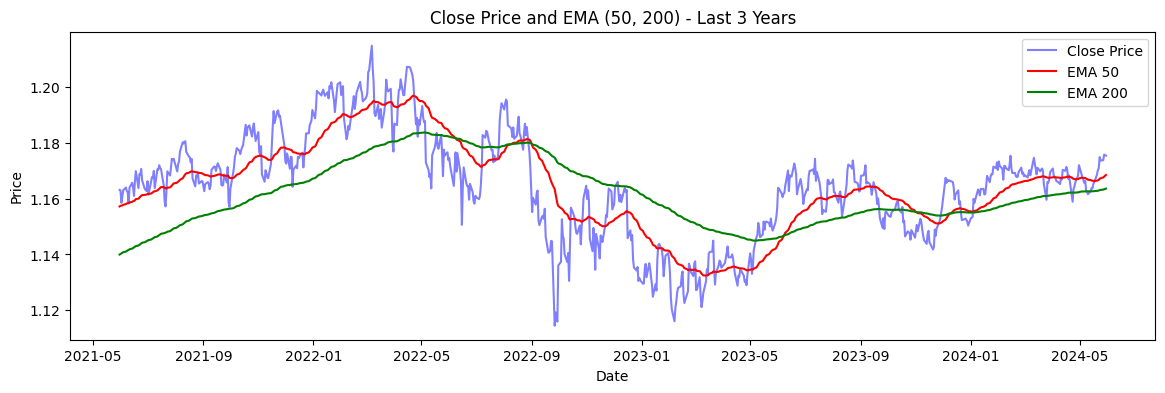

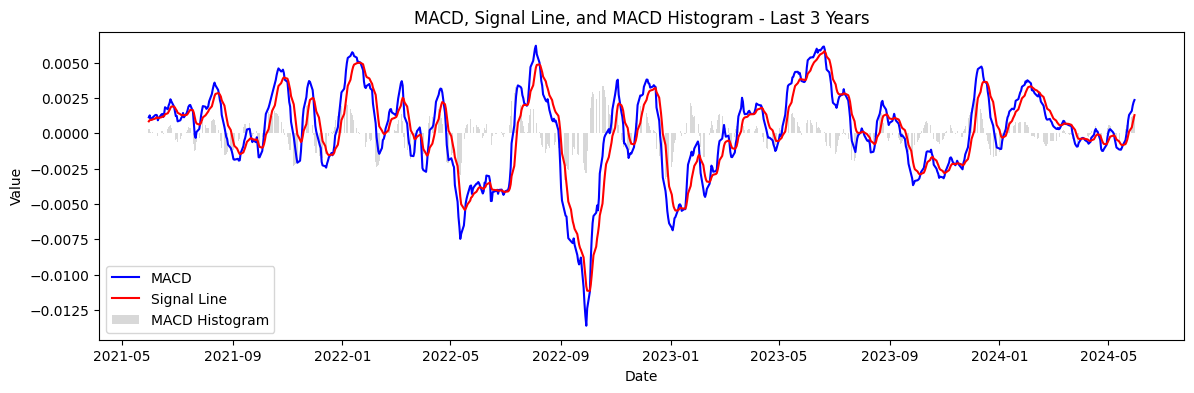

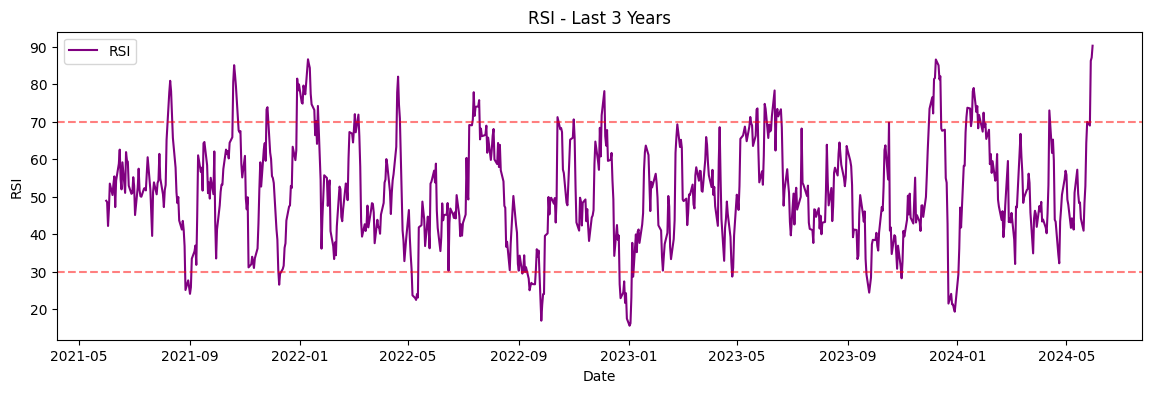

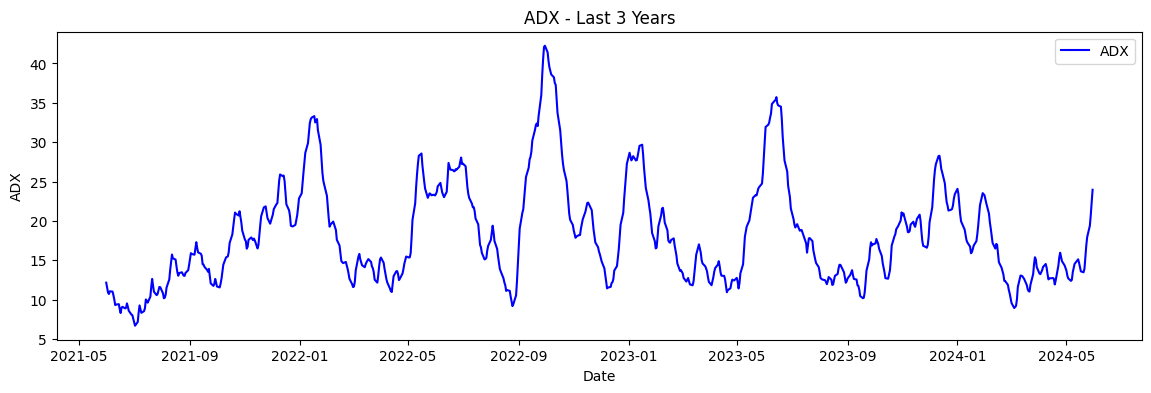

In [76]:
# Plot EMA
def plot_ema(df):
    """
    Plot the closing price along with EMA 50 and EMA 200.

    Parameters:
    df (DataFrame): DataFrame with 'Date', 'Close', 'EMA_50', and 'EMA_200' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(df['Date'], df['EMA_50'], label='EMA 50', color='red')
    plt.plot(df['Date'], df['EMA_200'], label='EMA 200', color='green')
    plt.title('Close Price and EMA (50, 200) - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_ema(df_last_three_years)

# Plot MACD
def plot_macd(df):
    """
    Plot MACD, Signal Line, and MACD Histogram.

    Parameters:
    df (DataFrame): DataFrame with 'Date', 'MACD', 'MACD_Signal', and 'MACD_Histogram' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
    plt.plot(df['Date'], df['MACD_Signal'], label='Signal Line', color='red')
    plt.bar(df['Date'], df['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.3)
    plt.title('MACD, Signal Line, and MACD Histogram - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_macd(df_last_three_years)

# Plot RSI
def plot_rsi(df):
    """
    Plot the RSI with overbought and oversold lines.

    Parameters:
    df (DataFrame): DataFrame with 'Date' and 'RSI' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(30, linestyle='--', alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.title('RSI - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

plot_rsi(df_last_three_years)

# Plot ADX
def plot_adx(df):
    """
    Plot the ADX.

    Parameters:
    df (DataFrame): DataFrame with 'Date' and 'ADX' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['ADX'], label='ADX', color='blue')
    #plt.plot(df['Date'], df['Plus_DI'], label='Plus DI', color='green')
    #plt.plot(df['Date'], df['Minus_DI'], label='Minus DI', color='red')
    plt.title('ADX - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('ADX')
    plt.legend()
    plt.show()

plot_adx(df_last_three_years)


In [77]:
indicators = cleaned_stock_data[['Open','High', 'Low', 'Close', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI']]

# Calculate the correlation matrix
correlation_matrix = indicators.corr()

# Display the correlation matrix
correlation_matrix


,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Open,1.000000,0.999575,0.999504,0.999599,0.989441,0.955766,0.106554,0.111503,0.007085,0.067560,0.083503,0.042413,-0.057127
High,0.999575,1.000000,0.999338,0.999564,0.989732,0.956914,0.102799,0.107504,0.007042,0.066714,0.087726,0.045250,-0.059134
Low,0.999504,0.999338,1.000000,0.999531,0.988697,0.954224,0.108630,0.113200,0.008630,0.070012,0.079412,0.047265,-0.062775
Close,0.999599,0.999564,0.999531,1.000000,0.989092,0.955349,0.107607,0.111537,0.010316,0.071408,0.082768,0.045733,-0.060480
EMA_50,0.989441,0.989732,0.988697,0.989092,1.000000,0.979773,-0.029805,-0.011962,-0.058905,-0.037607,0.129580,-0.054184,0.044490
EMA_200,0.955766,0.956914,0.954224,0.955349,0.979773,1.000000,-0.111594,-0.109808,-0.028051,-0.066882,0.170346,-0.076282,0.099267
MACD,0.106554,0.102799,0.108630,0.107607,-0.029805,-0.111594,1.000000,0.948852,0.355415,0.687510,-0.325195,0.608050,-0.633788
MACD_Signal,0.111503,0.107504,0.113200,0.111537,-0.011962,-0.109808,0.948852,1.000000,0.042129,0.495578,-0.335454,0.480071,-0.523278
MACD_Histogram,0.007085,0.007042,0.008630,0.010316,-0.058905,-0.028051,0.355415,0.042129,1.000000,0.708469,-0.035965,0.502925,-0.456454
RSI,0.067560,0.066714,0.070012,0.071408,-0.037607,-0.066882,0.687510,0.495578,0.708469,1.000000,-0.146697,0.678265,-0.657802


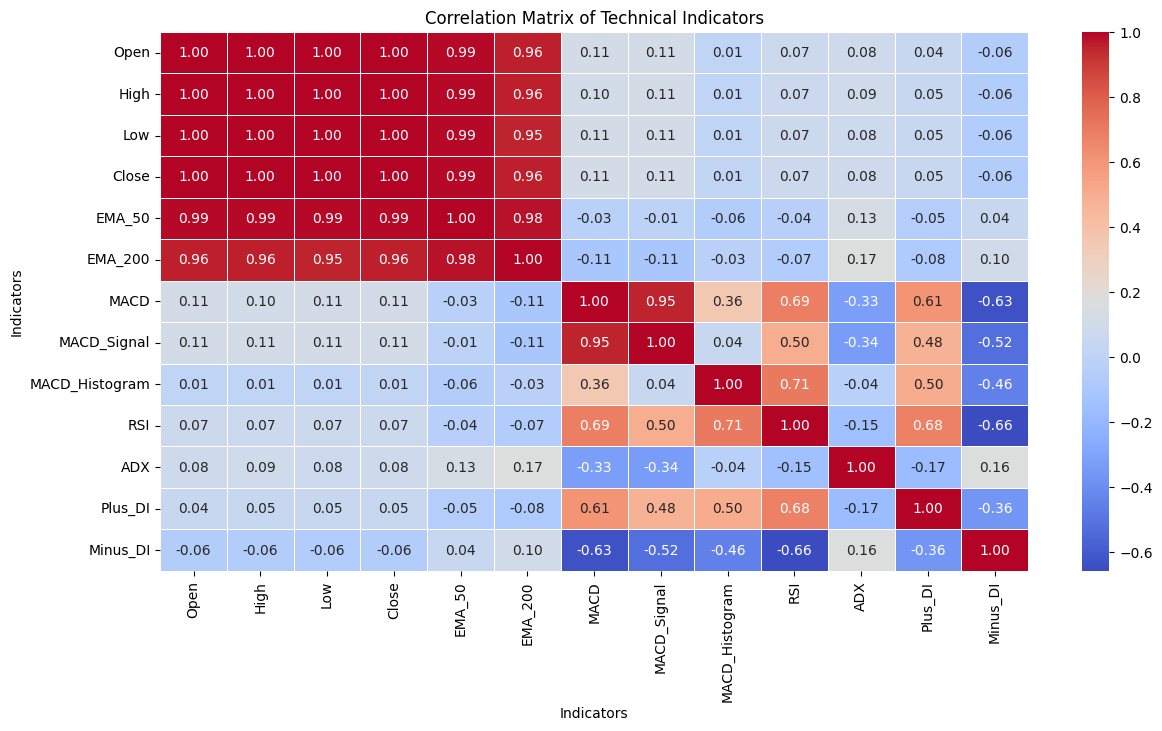

In [78]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 7))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add titles and labels
plt.title('Correlation Matrix of Technical Indicators')
plt.xlabel('Indicators')
plt.ylabel('Indicators')

# Show the plot
plt.show()


Recommending indicators combinations based on the correlation matrix

High Correlation: Indicators that are highly correlated often provide similar information about the market. Using multiple highly correlated indicators can lead to redundancy, making your strategy less effective

Low or Negative Correlation: Indicators with low or negative correlation can provide different perspectives on the market. Combining such indicators can create a more robust strategy.

EMA 50 and EMA 200:

EMA 50: Represents medium-term trends.
EMA 200: Very long-term trend indicator, useful for identifying the overall market direction.

Generate buy/sell signals based on EMA crossover and RSI

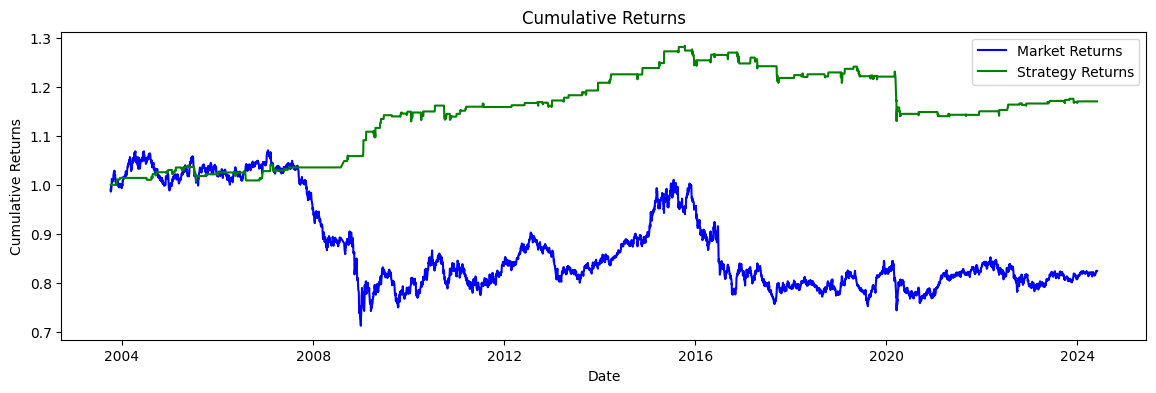

In [79]:
def generate_signals(df):
    """
    Generate trading signals based on EMA and RSI.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'RSI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['RSI'] < 30), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['RSI'] > 70), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


Observations:

The strategy appears to perform significantly better than the market returns, particularly after 2008.
The strategy returns show a more stable and upward trend compared to the volatile market returns.
There are periods where the strategy returns are flat, indicating no trades were made during those times, likely because the conditions for the signals were not met.
The cumulative returns of the strategy show a steady increase, suggesting that the strategy was effective in capturing profitable trading opportunities and avoiding significant losses during market downturns.

Comparison and Insights:

Performance: The strategy returns consistently outperform the market returns, indicating that the trading strategy based on EMA (50, 200) and RSI has been effective in generating positive returns.
Risk Management: The strategy seems to manage risk better than the buy-and-hold approach, avoiding major downturns and achieving more stable growth.
Volatility: The market returns exhibit high volatility, whereas the strategy returns are smoother and show less fluctuation.
The use of EMA (50, 200) and RSI indicators has provided a robust trading strategy that outperforms the market returns over the period analyzed. This suggests that combining trend-following indicators (EMA crossover) with momentum indicators (RSI) can lead to a more effective trading strategy in the GBP/EUR forex market

Generate buy/sell signals based on EMA crossover, RSI and ADX

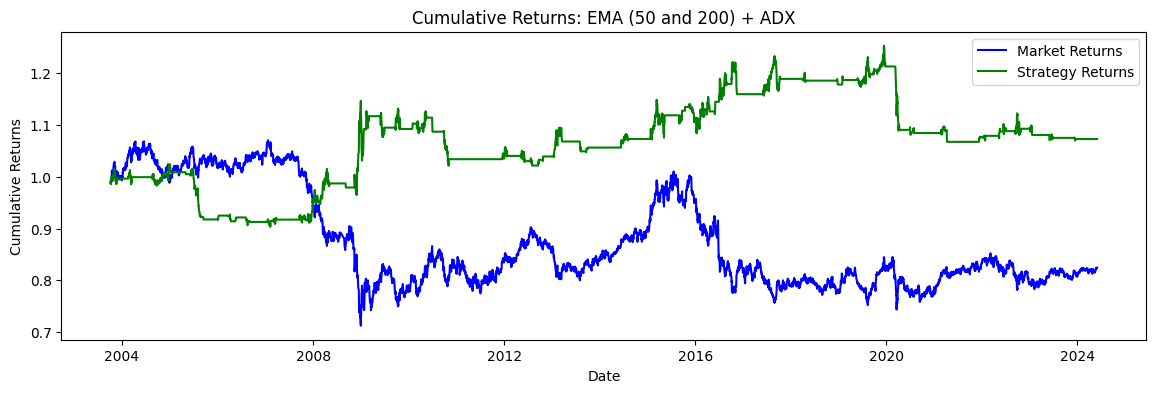

In [80]:
def generate_signals_ema_adx(df):
    """
    Generate trading signals based on EMA and ADX.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'ADX', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_ema_adx(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: EMA (50 and 200) + ADX')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



Observations:

The strategy returns show a more stable and upward trend compared to the volatile market returns.
The strategy appears to avoid major downturns, indicating effective risk management by not participating in trades during weaker trends (as indicated by ADX).
The cumulative returns from the strategy exhibit fewer fluctuations and more consistent growth, suggesting the combination of EMA, RSI, and ADX is effective in identifying profitable trades and avoiding significant losses.

Comparison and Insights:

Performance: The strategy returns consistently outperform the market returns, indicating that the combined use of EMA, RSI, and ADX has been effective in generating positive returns and managing risk.
Risk Management: The strategy's ability to avoid major declines seen in the market returns suggests strong risk management. The ADX helps in avoiding trades during weak trends, while the EMA and RSI help in capturing profitable trends.
Volatility: The market returns exhibit high volatility and significant drawdowns, whereas the strategy returns are smoother and show more stable growth.

Generate buy/sell signals based on EMA crossover and ADX

Entry Signal: When the EMA 50 crosses above EMA 200 and ADX is above 25 (indicating a strong trend), consider entering a long position. Conversely, when EMA 50 crosses below EMA 200 and ADX is above 25, consider a short position.

Exit Signal: Exit when the ADX falls below 20, indicating a weakening trend, or when there is a reverse crossover of the EMAs.

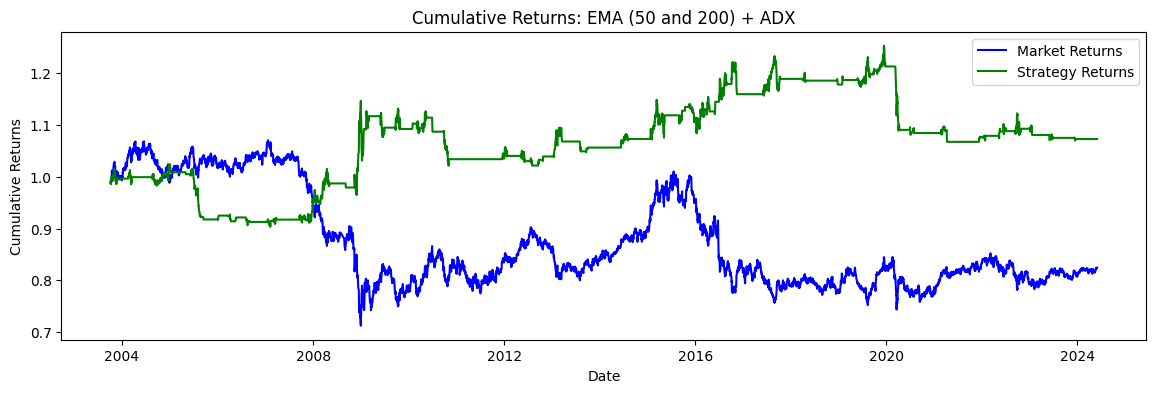

In [81]:
import matplotlib.pyplot as plt

def generate_signals_ema_adx(df):
    """
    Generate trading signals based on EMA and ADX.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'ADX', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_ema_adx(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: EMA (50 and 200) + ADX')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()




Generate buy/sell signals based on RSI and Plus/Minus DI

Entry Signal: Look for long positions when RSI is below 30 (oversold) and Plus_DI is above Minus_DI (indicating upward momentum). For short positions, look for RSI above 70 (overbought) and Minus_DI above Plus_DI (indicating downward momentum).

Exit Signal: Exit when RSI returns to the neutral zone (40-60) or when the directional indicators reverse their positions.

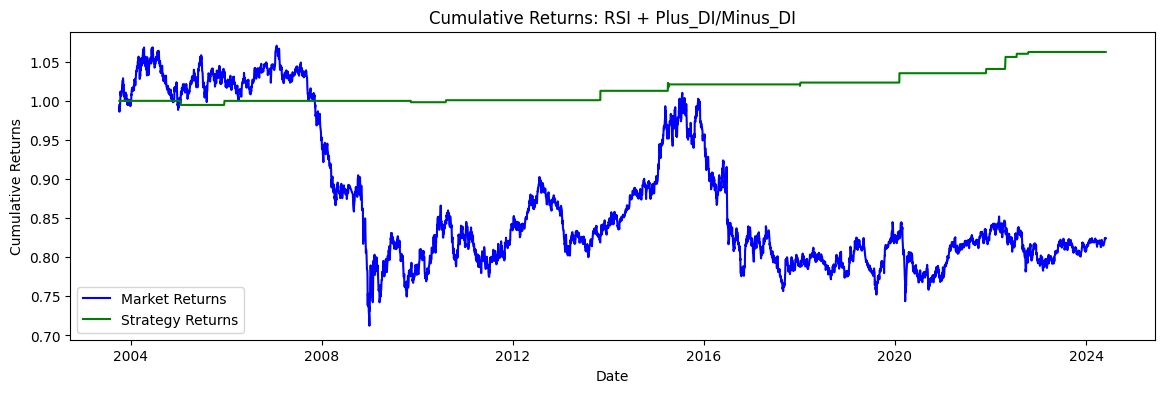

In [82]:
def generate_signals_rsi_di(df):
    """
    Generate trading signals based on RSI and Directional Indicators.

    Parameters:
    df (DataFrame): DataFrame with 'RSI', 'Plus_DI', 'Minus_DI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['RSI'] < 30) & (df['Plus_DI'] > df['Minus_DI']), 'Signal'] = 1
    df.loc[(df['RSI'] > 70) & (df['Minus_DI'] > df['Plus_DI']), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_rsi_di(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: RSI + Plus_DI/Minus_DI')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



Generate buy/sell signals based on MACD and RSI

Entry Signal: Consider entering a long position when the MACD line crosses above the signal line and the RSI is below 30 (oversold) moving upwards. For short positions, look for the MACD line crossing below the signal line and RSI above 70 (overbought) moving downwards.

Exit Signal: Exit when the MACD histogram starts to show divergence from the MACD line, or when RSI approaches the neutral zone

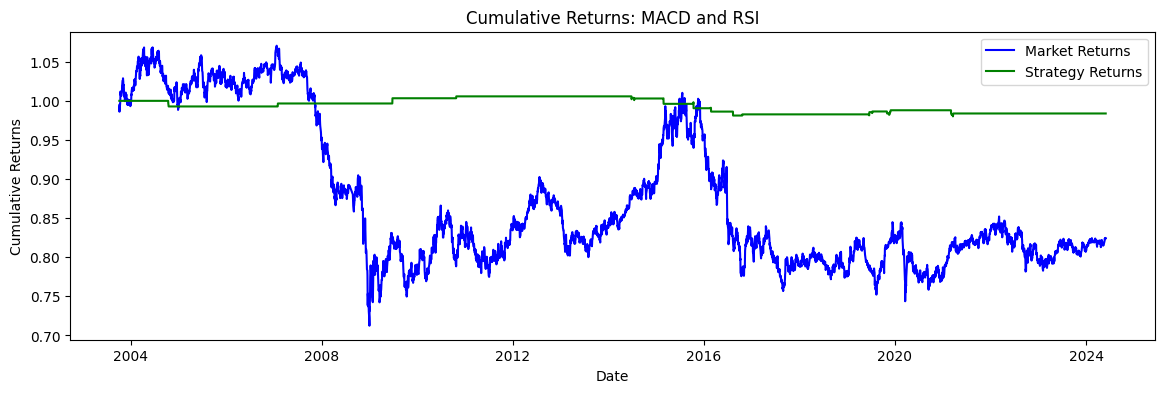

In [83]:
def generate_signals_macd_rsi(df):
    """
    Generate trading signals based on MACD and RSI.

    Parameters:
    df (DataFrame): DataFrame with 'MACD', 'MACD_Signal', 'RSI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['MACD'] > df['MACD_Signal']) & (df['RSI'] < 30), 'Signal'] = 1
    df.loc[(df['MACD'] < df['MACD_Signal']) & (df['RSI'] > 70), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_macd_rsi(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: MACD and RSI')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



In [84]:
cleaned_stock_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,Signal,Returns,Strategy_Returns,Cumulative_Strategy_Returns,Cumulative_Market_Returns
13,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990,0,NaN,NaN,NaN,NaN
14,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958,0,-0.010030,-0.0,1.0,0.989970
15,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317,0,-0.003897,-0.0,1.0,0.986112
16,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339,0,0.009460,0.0,1.0,0.995441
17,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697,0,-0.006342,-0.0,1.0,0.989128


In [85]:
#df_cleaned = df_cleaned.drop(columns=['Returns', 'Strategy_Returns', 'Cumulative_Strategy_Returns', 'Cumulative_Market_Returns'])
# List of columns to drop
columns_to_drop = ['Signal','Returns', 'Strategy_Returns', 'Cumulative_Strategy_Returns', 'Cumulative_Market_Returns']

# Check if columns exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in cleaned_stock_data.columns]

# Drop the existing columns from the DataFrame
cleaned_stock_data = cleaned_stock_data.drop(columns=existing_columns_to_drop)

# Display the resulting DataFrame to confirm
cleaned_stock_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
13,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990
14,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958
15,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317
16,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339
17,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697


In [86]:
cleaned_stock_data.shape

(5360, 14)

In [87]:
cleaned_stock_data.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
EMA_50            0
EMA_200           0
MACD              0
MACD_Signal       0
MACD_Histogram    0
RSI               0
ADX               0
Plus_DI           0
Minus_DI          0
dtype: int64

Adding more sample point using the jittering method

In [88]:
def jitter(data, noise_level=0.01):
    """
    Add random noise to the data.

    Purpose:
    This function is used to introduce variability into the data by adding random noise,
    which can help in augmenting the dataset to make the model more robust.

    Parameters:
    data (numpy array): Numeric data to which noise will be added.
    noise_level (float): The standard deviation of the normal distribution from which the noise is generated.

    Returns:
    numpy array: Data with added noise.
    """
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def resample_and_jitter(df, n_samples):
    """
    Resample the dataframe and add jitter (random noise) to the numeric columns.

    Purpose:
    This function increases the size of the dataset by resampling with replacement and
    adding jitter to numeric columns. This augmentation technique helps in creating
    additional synthetic data points, which can improve the training of GRU models
    by providing more varied data.

    Parameters:
    df (DataFrame): The input dataframe to be resampled and jittered.
    n_samples (int): The number of samples to draw with replacement from the dataframe.

    Returns:
    DataFrame: Resampled dataframe with added jitter to numeric columns.
    """
    resampled_df = df.sample(n=n_samples, replace=True).reset_index(drop=True)
    for column in resampled_df.select_dtypes(include=[np.number]).columns:
        resampled_df[column] = jitter(resampled_df[column].values)
    return resampled_df

# Number of additional samples to generate
additional_samples = 1000

# Generate additional samples
df_resampled = resample_and_jitter(cleaned_stock_data, additional_samples)

# Combine the original and resampled dataframes
augmented_data = pd.concat([cleaned_stock_data, df_resampled], ignore_index=True)
augmented_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
0,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990
1,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958
2,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317
3,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339
4,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697


Generate Synthetic Data with Bootstrapping
For forex market prediction, a combination of synthetic data generation and bootstrapping can be effective. This approach allows you to create new, realistic data points while preserving temporal dependencies.

In [89]:
augmented_data.shape

(6360, 14)

In [90]:
augmented_data.describe()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
count,6360,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000
mean,2014-02-27 12:14:56.603773440,1.241976,1.246093,1.237763,1.241958,1.242967,1.246653,-0.000304,-0.000335,-0.000030,50.353382,21.508319,19.570264,20.629774
min,2003-10-06 00:00:00,1.015700,1.032400,1.015700,1.015700,1.086984,1.095827,-0.046764,-0.055425,-0.039903,0.000000,6.682093,4.272195,3.974481
25%,2009-01-20 18:00:00,1.146129,1.149880,1.141600,1.146187,1.145845,1.149412,-0.003867,-0.003603,-0.001328,39.316543,14.983320,15.302182,15.982819
50%,2014-03-20 12:00:00,1.181480,1.185465,1.177500,1.181410,1.178460,1.182122,0.000278,0.000284,0.000063,50.478469,19.697600,19.214843,19.825247
75%,2019-04-25 06:00:00,1.341925,1.347310,1.336225,1.341700,1.354198,1.351055,0.003838,0.003482,0.001332,61.708985,25.763808,23.307902,24.214301
max,2024-05-30 00:00:00,1.531401,1.529764,1.521400,1.533599,1.515676,1.500215,0.041290,0.033586,0.029375,92.187500,55.128315,54.906334,74.671398
std,NaN,0.129555,0.129744,0.129395,0.129611,0.128744,0.125754,0.007354,0.007023,0.004416,15.628709,8.506505,6.057031,7.092696


In [91]:
cleaned_stock_data.describe()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
count,5360,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000
mean,2014-02-10 21:24:10.746268672,1.242401,1.246415,1.238243,1.242376,1.243569,1.247268,-0.000343,-0.000342,-5.443901e-07,50.275171,21.524771,19.515974,20.667871
min,2003-10-06 00:00:00,1.015700,1.032400,1.015700,1.015700,1.097439,1.114595,-0.041236,-0.037740,-9.353089e-03,0.000000,6.682093,4.272195,3.974481
25%,2008-12-29 18:00:00,1.145595,1.149495,1.141300,1.145600,1.145794,1.149658,-0.003378,-0.003174,-1.102898e-03,39.191987,15.038272,15.265371,15.965960
50%,2014-02-18 12:00:00,1.181495,1.185655,1.177590,1.181555,1.178362,1.182035,0.000289,0.000324,5.897261e-05,50.408761,19.747609,19.147867,19.897931
75%,2019-04-11 06:00:00,1.346400,1.350850,1.340793,1.346425,1.358130,1.353951,0.003482,0.003159,1.146611e-03,61.664131,25.836343,23.243162,24.280666
max,2024-05-30 00:00:00,1.526200,1.529500,1.521400,1.526200,1.503794,1.484090,0.018794,0.017209,1.413437e-02,92.187500,55.128315,54.906334,74.671398
std,NaN,0.130136,0.130218,0.129980,0.130102,0.129137,0.126100,0.006272,0.005868,1.981974e-03,15.650205,8.496628,6.049170,7.075659


In [92]:
# Filter data for the past three years
three_years_prices = cleaned_stock_data['Date'].max() - pd.DateOffset(years=3)
df_last_three_years = cleaned_stock_data[cleaned_stock_data['Date'] >= three_years_prices]
df_last_three_years.head()

three_years_augmented_prices = augmented_data['Date'].max() - pd.DateOffset(years=3)
augented_df_last_three_years = augmented_data[augmented_data['Date'] >= three_years_prices]
augented_df_last_three_years.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
4576,2021-05-31,1.16310,1.16388,1.16050,1.16314,1.157217,1.139960,0.001130,0.000848,0.000283,48.898116,12.151276,26.123530,19.765260
4577,2021-06-01,1.16282,1.16447,1.15640,1.16296,1.157443,1.140189,0.001270,0.000932,0.000338,48.553259,11.503596,24.085034,22.644024
4578,2021-06-02,1.15846,1.16265,1.15757,1.15853,1.157485,1.140372,0.001012,0.000948,0.000064,42.171717,10.902179,22.123734,20.800069
4579,2021-06-03,1.16063,1.16453,1.15985,1.16056,1.157606,1.140572,0.000960,0.000951,0.000010,46.675787,10.713689,22.580354,19.133413
4580,2021-06-04,1.16288,1.16733,1.16250,1.16300,1.157817,1.140796,0.001103,0.000981,0.000122,53.483269,11.056005,23.667516,17.313026


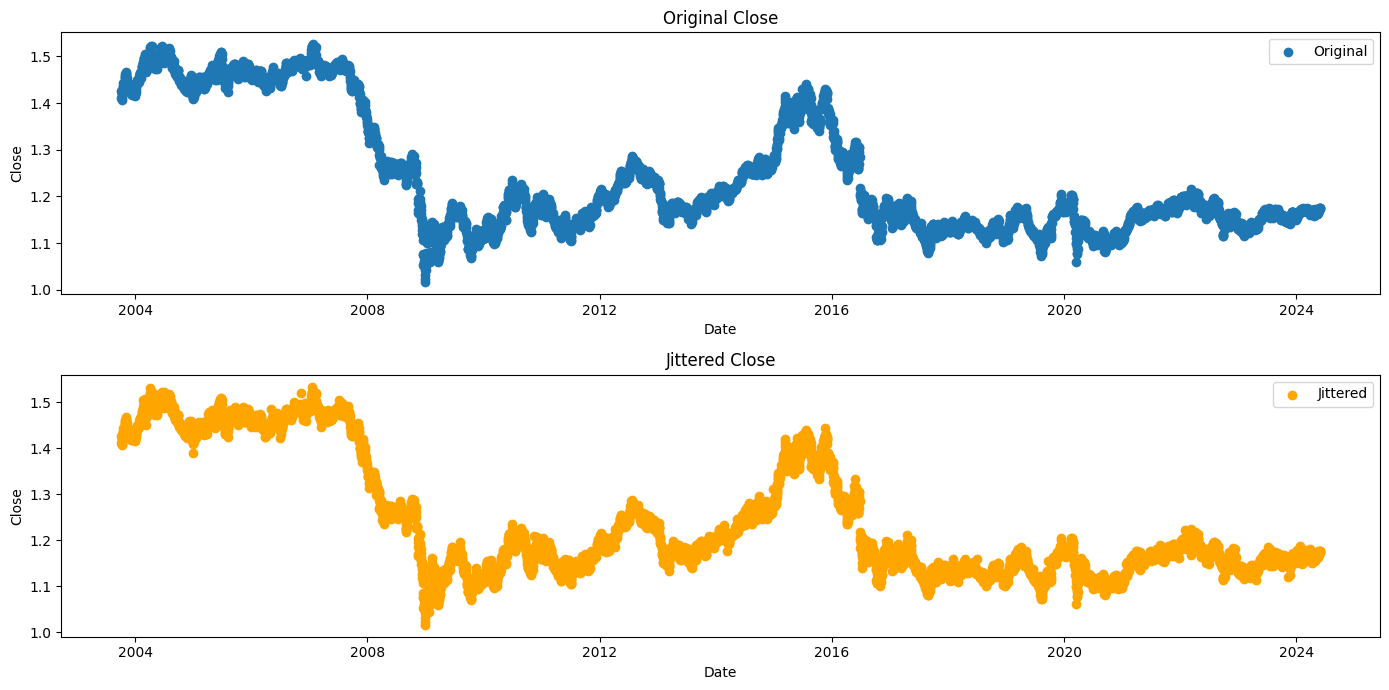

In [93]:
# Plot original and jittered data for comparison
def plot_comparison(df_original, df_jittered, column_name):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.scatter(df_original['Date'], df_original[column_name], label='Original')
    plt.title(f'Original {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.scatter(df_jittered['Date'], df_jittered[column_name], label='Jittered', color='orange')
    plt.title(f'Jittered {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Put date in datetime format
cleaned_stock_data['Date'] = pd.to_datetime(cleaned_stock_data['Date'])
augmented_data['Date'] = pd.to_datetime(augmented_data['Date'])


plot_comparison(cleaned_stock_data, augmented_data, 'Close')


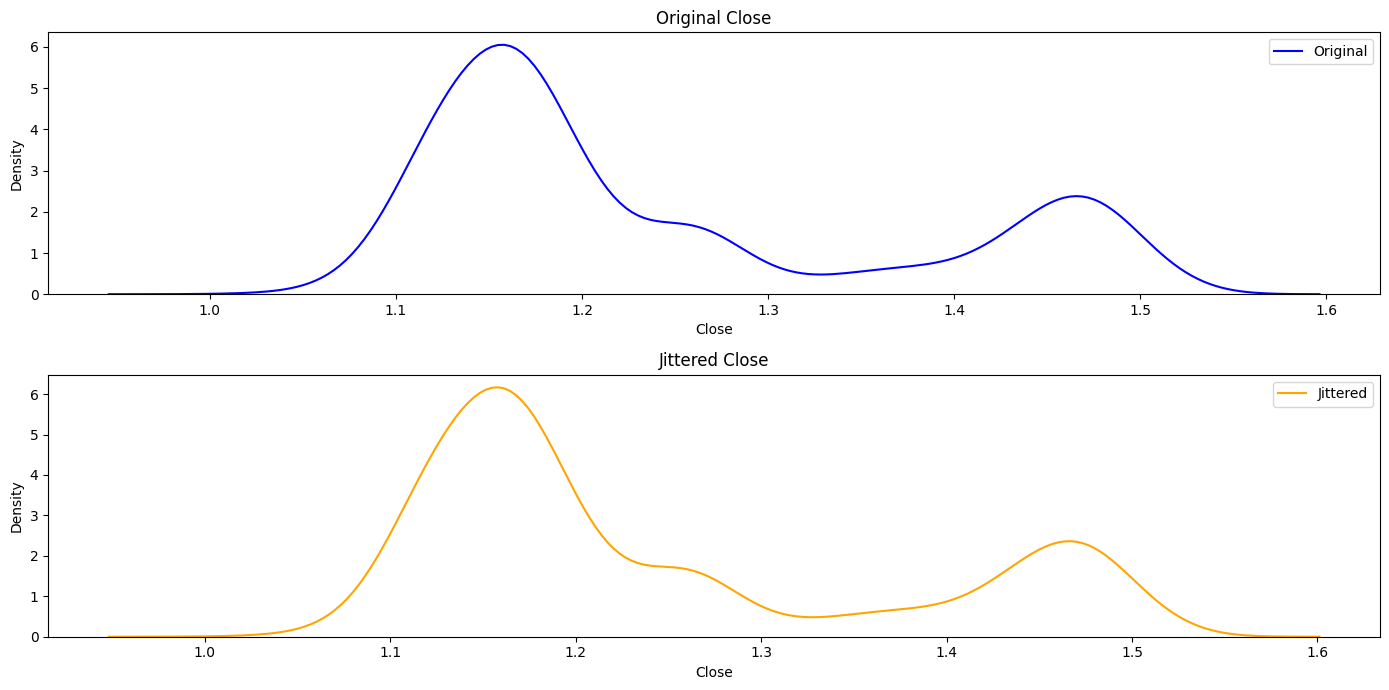

In [94]:
# Density Plot
def plot_density(df_original, df_jittered, column_name):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    sns.kdeplot(df_original[column_name], label='Original', color='blue')
    plt.title(f'Original {column_name}')
    plt.xlabel(column_name)
    plt.legend()

    plt.subplot(2, 1, 2)
    sns.kdeplot(df_jittered[column_name], label='Jittered', color='orange')
    plt.title(f'Jittered {column_name}')
    plt.xlabel(column_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example for the 'Close' column
plot_density(cleaned_stock_data, augmented_data, 'Close')

Modelling

GRU

The model will be using the close price as the target variable because it reflects the final price at which the asset was traded at the end of the trading day. It is often seen as the most representative of the asset's value for that day because it incorporates all the market activity and sentiment up until the market close.

In [95]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Helper function to create lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    return df.dropna()

# Data preparation
df_copy = cleaned_stock_data.copy()
dates = df_copy['Date'].reset_index(drop=True)

# Prepare data using lagged features for GRU, XGBoost, and Gaussian Process
df_lagged = create_lagged_features(df_copy, 'Close', lags=15)
X_lagged = df_lagged.drop(columns=['Close', 'Date']).values
y_lagged = df_lagged['Close'].values
dates_lagged = df_lagged['Date'].values

# Split data into train, validation, and test sets
X_train_lagged, X_temp_lagged, y_train_lagged, y_temp_lagged, dates_train_lagged, dates_temp_lagged = train_test_split(X_lagged, y_lagged, dates_lagged, test_size=0.3, shuffle=False)
X_val_lagged, X_test_lagged, y_val_lagged, y_test_lagged, dates_val_lagged, dates_test_lagged = train_test_split(X_temp_lagged, y_temp_lagged, dates_temp_lagged, test_size=0.5, shuffle=False)


In [97]:

# Normalize and reshape data for GRU model
scaler = MinMaxScaler()
X_train_lagged_scaled = scaler.fit_transform(X_train_lagged)
X_val_lagged_scaled = scaler.transform(X_val_lagged)
X_test_lagged_scaled = scaler.transform(X_test_lagged)

def create_sequences(data, target, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 15
X_train_gru, y_train_gru = create_sequences(X_train_lagged_scaled, y_train_lagged, sequence_length)
X_val_gru, y_val_gru = create_sequences(X_val_lagged_scaled, y_val_lagged, sequence_length)
X_test_gru, y_test_gru = create_sequences(X_test_lagged_scaled, y_test_lagged, sequence_length)

# Adjust dates for the sequence length
dates_train_gru = dates_train_lagged[sequence_length:]
dates_val_gru = dates_val_lagged[sequence_length:]
dates_test_gru = dates_test_lagged[sequence_length:]

# Build and train GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
gru_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru = gru_model.fit(X_train_gru, y_train_gru, epochs=100, batch_size=32, validation_data=(X_val_gru, y_val_gru), callbacks=[early_stopping])

# Plot training & validation loss values for GRU
plt.figure(figsize=(14, 5))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions with GRU model
y_pred_gru = gru_model.predict(X_test_gru)

# Inverse transform predictions for evaluation
y_test_gru = y_test_gru.reshape(-1, 1)
y_pred_gru = y_pred_gru.reshape(-1, 1)

inverse_transform_data_test_gru = np.hstack((np.zeros((y_test_gru.shape[0], X_train_lagged.shape[1] - 1)), y_test_gru))
inverse_transform_data_pred_gru = np.hstack((np.zeros((y_pred_gru.shape[0], X_train_lagged.shape[1] - 1)), y_pred_gru))

y_test_actual_gru = scaler.inverse_transform(inverse_transform_data_test_gru)[:, -1]
y_pred_actual_gru = scaler.inverse_transform(inverse_transform_data_pred_gru)[:, -1]

# Evaluate GRU Model Performance
mse_gru = mean_squared_error(y_test_actual_gru, y_pred_actual_gru)
mae_gru = mean_absolute_error(y_test_actual_gru, y_pred_actual_gru)
r2_gru = r2_score(y_test_actual_gru, y_pred_actual_gru)

print(f'GRU Model Mean Squared Error: {mse_gru}')
print(f'GRU Model Mean Absolute Error: {mae_gru}')
print(f'GRU Model R² Score: {r2_gru}')

# Plot Actual vs Predicted Prices with dates on the x-axis for GRU model
plt.figure(figsize=(14, 5))
plt.plot(dates_test_gru, y_test_actual_gru, label='Actual Price')
plt.plot(dates_test_gru, y_pred_actual_gru, label='Predicted Price')
plt.title('Actual vs Predicted Prices (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting the residuals for GRU model
residuals_gru = y_test_actual_gru - y_pred_actual_gru
plt.figure(figsize=(14, 7))
plt.plot(dates_test_gru, residuals_gru, label='Residuals', color='green')
plt.title('Residuals of Predictions (GRU)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_128 (GRU)               (None, 15, 50)            11850     
                                                                 
 dropout_128 (Dropout)       (None, 15, 50)            0         
                                                                 
 gru_129 (GRU)               (None, 50)                15300     
                                                                 
 dropout_129 (Dropout)       (None, 50)                0         
                                                                 
 dense_64 (Dense)            (None, 1)                 51        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 (106.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
117

KeyboardInterrupt: 

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# Helper function to create lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    return df.dropna()

# Data preparation
df_copy = cleaned_stock_data.copy()
dates = df_copy['Date'].reset_index(drop=True)

# Prepare data using lagged features for GRU
df_lagged = create_lagged_features(df_copy, 'Close', lags=15)
X_lagged = df_lagged.drop(columns=['Close', 'Date']).values
y_lagged = df_lagged['Close'].values
dates_lagged = df_lagged['Date'].values

# Split data into train, validation, and test sets
X_train_lagged, X_temp_lagged, y_train_lagged, y_temp_lagged, dates_train_lagged, dates_temp_lagged = train_test_split(X_lagged, y_lagged, dates_lagged, test_size=0.3, shuffle=False)
X_val_lagged, X_test_lagged, y_val_lagged, y_test_lagged, dates_val_lagged, dates_test_lagged = train_test_split(X_temp_lagged, y_temp_lagged, dates_temp_lagged, test_size=0.5, shuffle=False)

# Normalize and reshape data for GRU model
scaler = MinMaxScaler()
X_train_lagged_scaled = scaler.fit_transform(X_train_lagged)
X_val_lagged_scaled = scaler.transform(X_val_lagged)
X_test_lagged_scaled = scaler.transform(X_test_lagged)

def create_sequences(data, target, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 15
X_train_gru, y_train_gru = create_sequences(X_train_lagged_scaled, y_train_lagged, sequence_length)
X_val_gru, y_val_gru = create_sequences(X_val_lagged_scaled, y_val_lagged, sequence_length)
X_test_gru, y_test_gru = create_sequences(X_test_lagged_scaled, y_test_lagged, sequence_length)

# Adjust dates for the sequence length
dates_train_gru = dates_train_lagged[sequence_length:]
dates_val_gru = dates_val_lagged[sequence_length:]
dates_test_gru = dates_test_lagged[sequence_length:]

# Function to create the GRU model
def create_gru_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_gru_model, verbose=0)

# Grid of hyperparameters to search
param_grid = {
    'units': [50, 64],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
grid_result = grid.fit(X_train_gru, y_train_gru, validation_data=(X_val_gru, y_val_gru), callbacks=[early_stopping])

# Summarize results
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

# Extract the best model
best_model = grid_result.best_estimator_.model

# Make predictions with the best model
y_pred_gru = best_model.predict(X_test_gru)

# Inverse transform predictions for evaluation
y_test_gru = y_test_gru.reshape(-1, 1)
y_pred_gru = y_pred_gru.reshape(-1, 1)

inverse_transform_data_test_gru = np.hstack((np.zeros((y_test_gru.shape[0], X_train_lagged.shape[1] - 1)), y_test_gru))
inverse_transform_data_pred_gru = np.hstack((np.zeros((y_pred_gru.shape[0], X_train_lagged.shape[1] - 1)), y_pred_gru))

y_test_actual_gru = scaler.inverse_transform(inverse_transform_data_test_gru)[:, -1]
y_pred_actual_gru = scaler.inverse_transform(inverse_transform_data_pred_gru)[:, -1]

# Evaluate GRU Model Performance
mse_gru = mean_squared_error(y_test_actual_gru, y_pred_actual_gru)
mae_gru = mean_absolute_error(y_test_actual_gru, y_pred_actual_gru)
r2_gru = r2_score(y_test_actual_gru, y_pred_actual_gru)

print(f'GRU Model Mean Squared Error: {mse_gru}')
print(f'GRU Model Mean Absolute Error: {mae_gru}')
print(f'GRU Model R² Score: {r2_gru}')

# Plot Actual vs Predicted Prices with dates on the x-axis for GRU model
plt.figure(figsize=(14, 5))
plt.plot(dates_test_gru, y_test_actual_gru, label='Actual Price')
plt.plot(dates_test_gru, y_pred_actual_gru, label='Predicted Price')
plt.title('Actual vs Predicted Prices (GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting the residuals for GRU model
residuals_gru = y_test_actual_gru - y_pred_actual_gru
plt.figure(figsize=(14, 7))
plt.plot(dates_test_gru, residuals_gru, label='Residuals', color='green')
plt.title('Residuals of Predictions (GRU)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Ensuring the necessary columns for modeling are available
df_copy = cleaned_stock_data.copy()

# Selecting the features and target variable
X = df_copy[['Close']].values  # Only the feature columns are needed for X
y = df_copy['Close'].values  # The target column
dates = df_copy['Date'].values

# First split: Train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(X, y, dates, test_size=0.3, shuffle=False)

# Second split: Validation (15%) and Test (15%) from the temp set
X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(X_temp, y_temp, dates_temp, test_size=0.5, shuffle=False)

# Initializing the StandardScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fitting the scaler on the training data and transforming both training, validation, and testing data for X features
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Creating sequences
def create_sequences(X, y, dates, time_steps=15):
    Xs, ys, ds = [], [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
        ds.append(dates[i+time_steps])
    return np.array(Xs), np.array(ys), np.array(ds)

# Defining the time step
time_steps = 15

# Creating sequences for training, validation, and testing
X_train_seq_gru, y_train_seq_gru, dates_train_seq_gru = create_sequences(X_train_scaled, y_train_scaled, dates_train, time_steps)
X_val_seq_gru, y_val_seq_gru, dates_val_seq_gru = create_sequences(X_val_scaled, y_val_scaled, dates_val, time_steps)
X_test_seq_gru, y_test_seq_gru, dates_test_seq_gru = create_sequences(X_test_scaled, y_test_scaled, dates_test, time_steps)

# Function to create the GRU model with hyperparameters
def create_gru_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(time_steps, X_train_seq_gru.shape[2])),
        Dropout(dropout_rate),
        GRU(units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Grid of hyperparameters to search
param_grid = {
    'units': [50, 64],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

best_score = float('inf')
best_params = None
best_model = None

# Manually iterate over the grid of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print(f'Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}')
                    model = create_gru_model(units, dropout_rate, learning_rate)
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    history = model.fit(X_train_seq_gru, y_train_seq_gru, epochs=epochs, batch_size=batch_size, validation_data=(X_val_seq_gru, y_val_seq_gru), callbacks=[early_stopping], verbose=0)

                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_score:
                        best_score = val_loss
                        best_params = (units, dropout_rate, learning_rate, batch_size, epochs)
                        best_model = model

print(f'Best parameters: {best_params}')
print(f'Best validation loss: {best_score}')

# Evaluate the best model on the test set
gru_predictions = best_model.predict(X_test_seq_gru)

# Inverse transform the predictions and actual values
gru_predictions = scaler_y.inverse_transform(gru_predictions)
y_test_seq_inverse_gru = scaler_y.inverse_transform(y_test_seq_gru)

# Compute metrics
mse = mean_squared_error(y_test_seq_inverse_gru, gru_predictions)
mae = mean_absolute_error(y_test_seq_inverse_gru, gru_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq_inverse_gru, gru_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_test_seq_gru, y_test_seq_inverse_gru, label='Actual', color='blue')
plt.plot(dates_test_seq_gru, gru_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

# Plotting the residuals
residuals = y_test_seq_gru - gru_predictions
plt.figure(figsize=(14, 7))
plt.plot(dates_test_seq_gru, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

In [ ]:

# Train and evaluate XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_lagged, y_train_lagged, eval_set=[(X_val_lagged, y_val_lagged)], early_stopping_rounds=10, verbose=False)

# Make predictions with XGBoost model
y_pred_xgb = xgb_model.predict(X_test_lagged)

# Compute metrics for XGBoost model
mse_xgb = mean_squared_error(y_test_lagged, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_lagged, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_lagged, y_pred_xgb)

print(f'XGBoost Model Mean Squared Error: {mse_xgb}')
print(f'XGBoost Model Mean Absolute Error: {mae_xgb}')
print(f'XGBoost Model Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost Model R² Score: {r2_xgb}')

# Plot Actual vs Predicted Prices with dates on the x-axis for XGBoost model
plt.figure(figsize=(12, 6))
plt.plot(dates_test_lagged, y_test_lagged, label='Actual', color='blue')
plt.plot(dates_test_lagged, y_pred_xgb, label='Predicted', color='red')
plt.title('Actual vs Predicted Close Prices (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

# Plotting the residuals for XGBoost model
residuals_xgb = y_test_lagged - y_pred_xgb
plt.figure(figsize=(14, 7))
plt.plot(dates_test_lagged, residuals_xgb, label='Residuals', color='green')
plt.title('Residuals of Predictions (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()


In [ ]:

# Train and evaluate Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Lists to store the training and validation losses
train_losses_gpr = []
val_losses_gpr = []

# Custom training loop to track losses
for i in range(1, 11):
    gpr_model.fit(X_train_lagged, y_train_lagged)

    y_train_pred_gpr, _ = gpr_model.predict(X_train_lagged, return_std=True)
    y_val_pred_gpr, _ = gpr_model.predict(X_val_lagged, return_std=True)

    train_loss_gpr = mean_squared_error(y_train_lagged, y_train_pred_gpr)
    val_loss_gpr = mean_squared_error(y_val_lagged, y_val_pred_gpr)

    train_losses_gpr.append(train_loss_gpr)
    val_losses_gpr.append(val_loss_gpr)

    print(f'Iteration {i} - Train Loss: {train_loss_gpr:.4f}, Validation Loss: {val_loss_gpr:.4f}')

# Plotting the training and validation losses for Gaussian Process
plt.figure(figsize=(14, 7))
plt.plot(range(1, 11), train_losses_gpr, label='Train Loss')
plt.plot(range(1, 11), val_losses_gpr, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations (Gaussian Process)')
plt.legend()
plt.show()

# Make predictions with Gaussian Process model
y_pred_gpr, sigma_gpr = gpr_model.predict(X_test_lagged, return_std=True)

# Compute metrics for Gaussian Process model
mse_gpr = mean_squared_error(y_test_lagged, y_pred_gpr)
mae_gpr = mean_absolute_error(y_test_lagged, y_pred_gpr)
rmse_gpr = np.sqrt(mse_gpr)
r2_gpr = r2_score(y_test_lagged, y_pred_gpr)

print(f'Gaussian Process Model Mean Squared Error: {mse_gpr}')
print(f'Gaussian Process Model Mean Absolute Error: {mae_gpr}')
print(f'Gaussian Process Model Root Mean Squared Error: {rmse_gpr}')
print(f'Gaussian Process Model R² Score: {r2_gpr}')

# Plot Actual vs Predicted Prices with dates on the x-axis for Gaussian Process model
plt.figure(figsize=(12, 6))
plt.plot(dates_test_lagged, y_test_lagged, label='Actual', color='blue')
plt.plot(dates_test_lagged, y_pred_gpr, label='Predicted', color='red')
plt.fill_between(dates_test_lagged, y_pred_gpr - 1.96 * sigma_gpr, y_pred_gpr + 1.96 * sigma_gpr, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Close Prices (Gaussian Process)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

# Plotting the residuals for Gaussian Process model
residuals_gpr = y_test_lagged - y_pred_gpr
plt.figure(figsize=(14, 7))
plt.plot(dates_test_lagged, residuals_gpr, label='Residuals', color='green')
plt.title('Residuals of Predictions (Gaussian Process)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming cleaned_stock_data is already defined and contains the required data

df_copy = cleaned_stock_data.copy()

# Extract date column and reset index
dates = df_copy['Date'].reset_index(drop=True)

# Drop non-numeric columns (excluding the Date column)
numeric_df = df_copy.drop(columns=['Date']).select_dtypes(include=[np.number])

# Normalize numeric features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert to DataFrame for easier manipulation
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

# Function to create sequences
def create_sequences(data, target_column, sequence_length=50):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length][target_column]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 50
target_column = 'Close'  # The column you want to predict

# Split the normalized data into train, validation, and test sets
train_size = int(len(scaled_df) * 0.7)
val_size = int(len(scaled_df) * 0.15)
test_size = len(scaled_df) - train_size - val_size

train_data = scaled_df[:train_size]
val_data = scaled_df[train_size:train_size + val_size]
test_data = scaled_df[train_size + val_size:]

# Split the dates accordingly
train_dates = dates[:train_size]
val_dates = dates[train_size:train_size + val_size]
test_dates = dates[train_size + val_size:]

# Create sequences for each set
X_train, y_train = create_sequences(train_data, target_column, sequence_length)
X_val, y_val = create_sequences(val_data, target_column, sequence_length)
X_test, y_test = create_sequences(test_data, target_column, sequence_length)

# Adjust dates for the sequence length
train_dates = train_dates[sequence_length:]
val_dates = val_dates[sequence_length:]
test_dates = test_dates[sequence_length:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions for evaluation
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Adding back the columns removed before normalization
inverse_transform_data_test = np.hstack((np.zeros((y_test.shape[0], scaled_df.shape[1]-1)), y_test))
inverse_transform_data_pred = np.hstack((np.zeros((y_pred.shape[0], scaled_df.shape[1]-1)), y_pred))

# Inverse transform to get actual values
y_test_actual = scaler.inverse_transform(inverse_transform_data_test)[:, -1]
y_pred_actual = scaler.inverse_transform(inverse_transform_data_pred)[:, -1]

# Evaluate Model Performance
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

# Plot Actual vs Predicted Prices with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, label='Actual Price')
plt.plot(test_dates, y_pred_actual, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting the residuals
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(14, 7))
plt.plot(dates_test, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with XGBoost')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming cleaned_stock_data is already defined and contains the required data

df_copy = augmented_data.copy()

# Extract date column and reset index
dates = df_copy['Date'].reset_index(drop=True)

# Drop non-numeric columns (excluding the Date column)
numeric_df = df_copy.drop(columns=['Date']).select_dtypes(include=[np.number])

# Normalize numeric features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert to DataFrame for easier manipulation
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

# Function to create sequences
def create_sequences(data, target_column, sequence_length=50):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length][target_column]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 50
target_column = 'Close'  # The column you want to predict

# Split the normalized data into train, validation, and test sets
train_size = int(len(scaled_df) * 0.7)
val_size = int(len(scaled_df) * 0.15)
test_size = len(scaled_df) - train_size - val_size

train_data = scaled_df[:train_size]
val_data = scaled_df[train_size:train_size + val_size]
test_data = scaled_df[train_size + val_size:]

# Split the dates accordingly
train_dates = dates[:train_size]
val_dates = dates[train_size:train_size + val_size]
test_dates = dates[train_size + val_size:]

# Create sequences for each set
X_train, y_train = create_sequences(train_data, target_column, sequence_length)
X_val, y_val = create_sequences(val_data, target_column, sequence_length)
X_test, y_test = create_sequences(test_data, target_column, sequence_length)

# Adjust dates for the sequence length
train_dates = train_dates[sequence_length:]
val_dates = val_dates[sequence_length:]
test_dates = test_dates[sequence_length:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions for evaluation
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Adding back the columns removed before normalization
inverse_transform_data_test = np.hstack((np.zeros((y_test.shape[0], scaled_df.shape[1]-1)), y_test))
inverse_transform_data_pred = np.hstack((np.zeros((y_pred.shape[0], scaled_df.shape[1]-1)), y_pred))

# Inverse transform to get actual values
y_test_actual = scaler.inverse_transform(inverse_transform_data_test)[:, -1]
y_pred_actual = scaler.inverse_transform(inverse_transform_data_pred)[:, -1]

# Evaluate Model Performance
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

# Plot Actual vs Predicted Prices with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, label='Actual Price')
plt.plot(test_dates, y_pred_actual, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Plotting the residuals
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(14, 7))
plt.plot(test_dates, residuals, label='Residuals', color='green') # Use test_dates instead of dates_test
plt.title('Residuals of Predictions with XGBoost')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
!pip install matplotlib
import matplotlib.dates as mdates # Make sure you have imported mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Ensure the necessary columns for modeling are available
df_copy = cleaned_stock_data.copy()

# Function to create lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

# Define target and features
target_column = 'Close'
df_lagged = create_lagged_features(df_copy, target_column)

# Splitting the data into features and target
X = df_lagged.drop(columns=[target_column, 'Date']).values
y = df_lagged[target_column].values
dates = df_lagged['Date'].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(X, y, dates, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(X_temp, y_temp, dates_temp, test_size=0.5, shuffle=False)

# Initialize and fit the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_pred_xgb, label='Predicted', color='red')
plt.title('Actual vs Predicted Close Prices with XGBoost')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

# Plotting the residuals
residuals = y_test - y_pred_xgb
plt.figure(figsize=(14, 7))
plt.plot(dates_test, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with XGBoost')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Ensure the necessary columns for modeling are available
df_copy = cleaned_stock_data.copy()

# Function to create lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

# Define target and features
target_column = 'Close'
df_lagged = create_lagged_features(df_copy, target_column)

# Splitting the data into features and target
X = df_lagged.drop(columns=[target_column, 'Date']).values
y = df_lagged[target_column].values
dates = df_lagged['Date'].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(X, y, dates, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(X_temp, y_temp, dates_temp, test_size=0.5, shuffle=False)

# Initialize and fit the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model with evaluation and track the evaluation results
#eval_result = {}

# After training the model, you can get the evaluation results like this:
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=10, eval_metric='rmse', verbose=False)

eval_result = xgb_model.evals_result()

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plot training and validation loss
epochs = len(eval_result['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(14, 7))
plt.plot(x_axis, eval_result['validation_0']['rmse'], label='Train')
plt.plot(x_axis, eval_result['validation_1']['rmse'], label='Validation')
plt.title('XGBoost Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_pred_xgb, label='Predicted', color='red')
plt.title('Actual vs Predicted Close Prices with XGBoost')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

# Plotting the residuals
residuals = y_test - y_pred_xgb
plt.figure(figsize=(14, 7))
plt.plot(dates_test, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with XGBoost')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Ensuring the necessary columns for modeling are available
df_copy = cleaned_stock_data.copy()

# Creating lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

# Define target and features
target_column = 'Close'
df_lagged = create_lagged_features(df_copy, target_column)

# Splitting the data into features and target
X = df_lagged.drop(columns=[target_column, 'Date']).values
y = df_lagged[target_column].values
dates = df_lagged['Date'].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(X, y, dates, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(X_temp, y_temp, dates_temp, test_size=0.5, shuffle=False)

# Initialize and fit the Gaussian Process model
# Define a kernel with an initial constant value and a RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Train the model
gpr_model.fit(X_train, y_train)

# Make predictions with uncertainty estimates
y_pred, sigma = gpr_model.predict(X_test, return_std=True)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plotting the predictions with uncertainty estimates
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_pred, label='Predicted', color='red')
plt.fill_between(dates_test, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Close Prices with Gaussian Process')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
plt.plot(dates_test, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with Gaussian Process')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Ensure the necessary columns for modeling are available
df_copy = cleaned_stock_data.copy()

# Function to create lagged features
def create_lagged_features(data, target_column, lags=15):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

# Define target and features
target_column = 'Close'
df_lagged = create_lagged_features(df_copy, target_column)

# Splitting the data into features and target
X = df_lagged.drop(columns=[target_column, 'Date']).values
y = df_lagged[target_column].values
dates = df_lagged['Date'].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(X, y, dates, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(X_temp, y_temp, dates_temp, test_size=0.5, shuffle=False)

# Initialize the Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Custom training loop to track losses
for i in range(1, 11):
    gpr_model.fit(X_train, y_train)

    # Predict on the training and validation sets
    y_train_pred, _ = gpr_model.predict(X_train, return_std=True)
    y_val_pred, _ = gpr_model.predict(X_val, return_std=True)

    # Compute the losses
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Iteration {i} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting the training and validation losses
plt.figure(figsize=(14, 7))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()

# Make predictions with uncertainty estimates
y_pred, sigma = gpr_model.predict(X_test, return_std=True)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plotting the predictions with uncertainty estimates
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_pred, label='Predicted', color='red')
plt.fill_between(dates_test, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Close Prices with Gaussian Process')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
plt.plot(dates_test, residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with Gaussian Process')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [ ]:
# Trained models
best_model_gru = model_gru
best_model_xgb = best_model_xgb
best_model_rf = best_model_rf

# Define file paths to save the models
gru_model_path1 = 'best_model_gru.h5'  # Using HDF5 format for Keras
xgb_model_path = 'best_model_xgb.json'
rf_model_path = 'best_model_rf.pkl'

# Save the GRU model using the HDF5 format
save_model(best_model_gru, gru_model_path1)
print(f"GRU model saved as '{gru_model_path1}'")

# Save the XGBoost model
best_model_xgb.save_model(xgb_model_path)
print(f"XGBoost model saved as '{xgb_model_path}'")

# Save the Random Forest model
dump(best_model_rf, rf_model_path)
print(f"Random Forest model saved as '{rf_model_path}'")

In [ ]:
import pandas as pd
import numpy as np

# Assume `X` is your feature set including technical indicators and price data
# Assume `y` is the target variable (future price)
X = cleaned_stock_data[['Open', 'High', 'Low', 'Close', 'RSI', 'EMA_50', 'EMA_200', 'ADX', 'Plus_DI', 'Minus_DI', 'MACD', 'MACD_Signal', 'MACD_Histogram']]
y_true = cleaned_stock_data['Close'].shift(-1)  # Next day closing price

# Generate predictions
y_pred_gru = y_pred_actual(X)
y_pred_xgboost =y_pred_xgb(X)
y_pred_gp = y_pred(X)

# Combine predictions with the original data
cleaned_stock_data['Pred_GRU'] = y_pred_gru
cleaned_stock_data['Pred_XGBoost'] = y_pred_xgboost
cleaned_stock_data['Pred_GP'] = y_pred_gp


In [ ]:
import pandas as pd
import numpy as np
import joblib  # For loading the models

# Load your models (replace 'model_gru.pkl', etc., with your actual model filenames)
model_gru = joblib.load('model_gru.pkl')
model_xgboost = joblib.load('model_xgboost.pkl')
model_gp = joblib.load('model_gp.pkl')

# Assume `X` is your feature set including technical indicators and price data
# Assume `y` is the target variable (future price)
X = cleaned_stock_data[['Open', 'High', 'Low', 'Close', 'RSI', 'EMA_50', 'EMA_200', 'ADX', 'Plus_DI', 'Minus_DI', 'MACD', 'MACD_Signal', 'MACD_Histogram']]
y_true = cleaned_stock_data['Close'].shift(-1)  # Next day closing price

# Generate predictions
y_pred_gru = model_gru.predict(X)
y_pred_xgboost = model_xgboost.predict(X)
y_pred_gp = model_gp.predict(X)

# Combine predictions with the original data
cleaned_stock_data['Pred_GRU'] = y_pred_gru
cleaned_stock_data['Pred_XGBoost'] = y_pred_xgboost
cleaned_stock_data['Pred_GP'] = y_pred_gp


In [ ]:
import pandas as pd
import numpy as np
import joblib  # For loading the models

# Load your data (make sure to replace with your actual data loading code)
#cleaned_stock_data = pd.read_csv('gbp_eur_data.csv', index_col='Date', parse_dates=True)

# Load your models (replace 'model_gru.pkl', etc., with your actual model filenames)
model_gru = joblib.load('model_gru.pkl')
model_xgboost = joblib.load('model_xgboost.pkl')
model_gp = joblib.load('model_gp.pkl')

# Assume `X` is your feature set including technical indicators and price data
# Assume `y` is the target variable (future price)
X = cleaned_stock_data[['Open', 'High', 'Low', 'Close', 'RSI', 'EMA_50', 'EMA_200', 'ADX', 'Plus_DI', 'Minus_DI', 'MACD', 'MACD_Signal', 'MACD_Histogram']]
y_true = cleaned_stock_data['Close'].shift(-1)  # Next day closing price

# Generate predictions
y_pred_gru = model_gru.predict(X)
y_pred_xgboost = model_xgboost.predict(X)
y_pred_gp = model_gp.predict(X)

# Combine predictions with the original data
cleaned_stock_data['Pred_GRU'] = y_pred_gru
cleaned_stock_data['Pred_XGBoost'] = y_pred_xgboost
cleaned_stock_data['Pred_GP'] = y_pred_gp


In [ ]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())


In [ ]:
# List all files in the current working directory
print("Files in the current directory:", os.listdir(os.getcwd()))

# List files in a specific directory (if you know where to look)
specific_directory = '/path/to/your/models'
print(f"Files in {specific_directory}:", os.listdir(specific_directory))
